# Chapter 9 Machine Learning in BigQuery

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from google.cloud import bigquery
import time

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [3]:
PROJECT = 'scalable-data-science'
DATASET = 'bq_ch09'

In [73]:
!bq --location=EU mk $DATASET 

Dataset 'scalable-data-science:bq_ch09' successfully created.


# 自転車のレンタル時間と30min以内に返却する確率を予測するmodelを生成する

## EDA

In [4]:
%%bigquery data --project $PROJECT

SELECT start_station_name
    , AVG(duration) AS duration
FROM `bigquery-public-data.london_bicycles.cycle_hire`
GROUP BY start_station_name

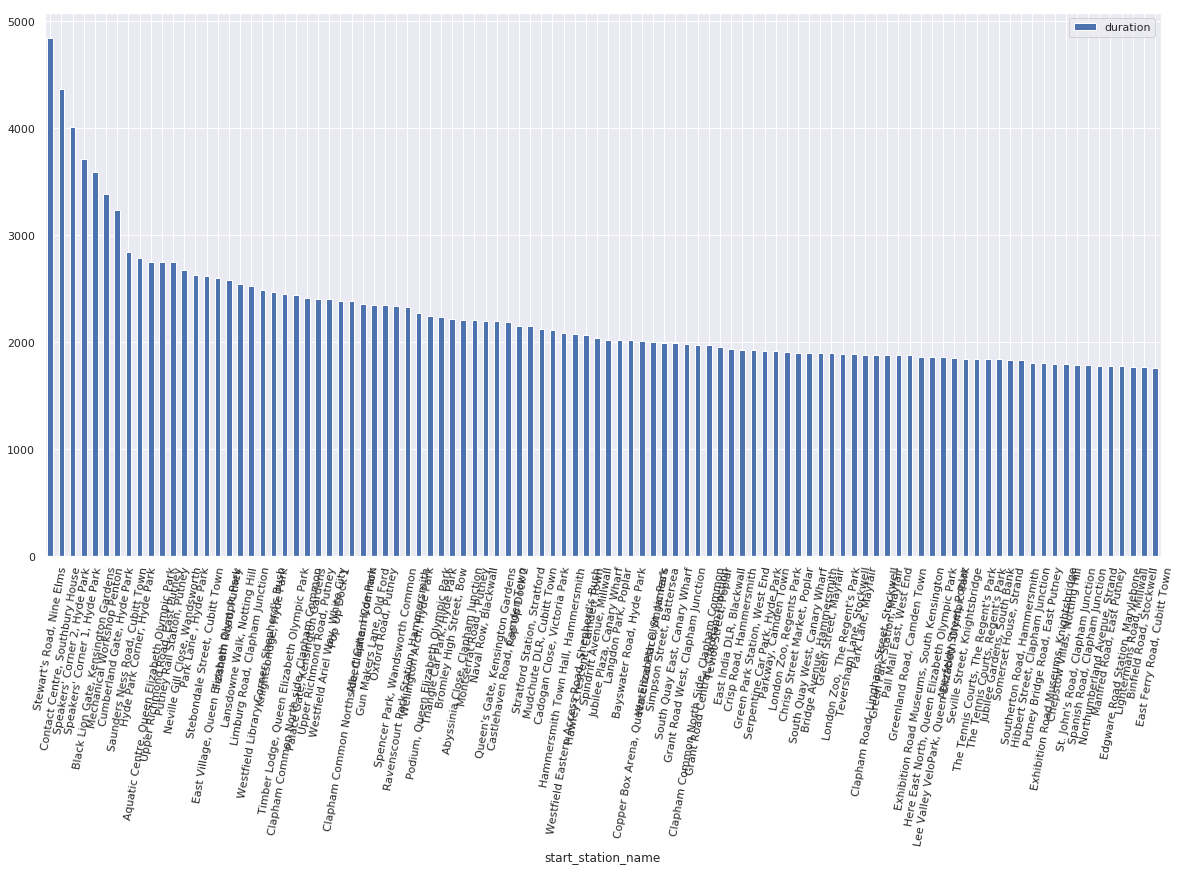

In [5]:
# 駅ごと
fig, ax = plt.subplots(figsize=(20,10))
data = data.sort_values('duration', ascending=False).head(100)
ax=data.plot(x='start_station_name', y='duration', kind='bar', ax=ax)
ax.xaxis.set_tick_params(rotation=80)

主要な駅はレンタル時間に大きな差はない

In [6]:
%%bigquery data --project $PROJECT

SELECT EXTRACT(dayofweek FROM start_date) AS dayofweek
    , AVG(duration) AS duration
FROM `bigquery-public-data.london_bicycles.cycle_hire`
GROUP BY dayofweek

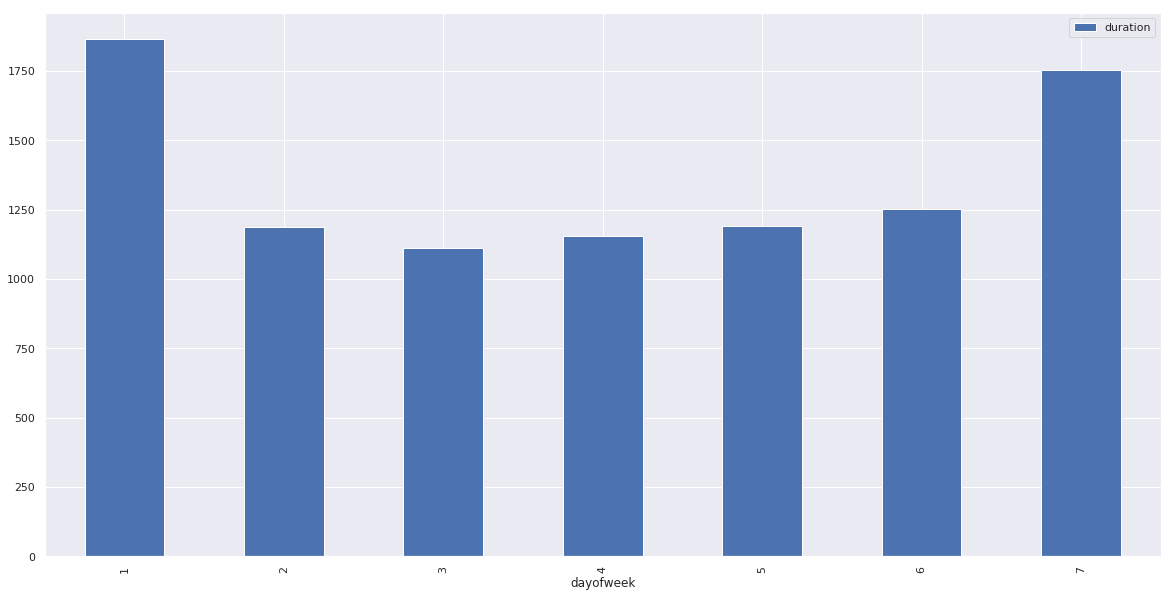

In [7]:
# 曜日ごと
fig, ax = plt.subplots(figsize=(20,10))
data = data.sort_values('dayofweek')
ax=data.plot(x='dayofweek', y='duration', kind='bar', ax=ax)

週末はレンタル時間が長い

In [8]:
%%bigquery data --project $PROJECT

SELECT bikes_count
    , AVG(duration) AS duration
FROM `bigquery-public-data.london_bicycles.cycle_hire`　AS ch
JOIN `bigquery-public-data.london_bicycles.cycle_stations` AS cs
ON ch.start_station_name = cs.name
GROUP BY cs.bikes_count

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


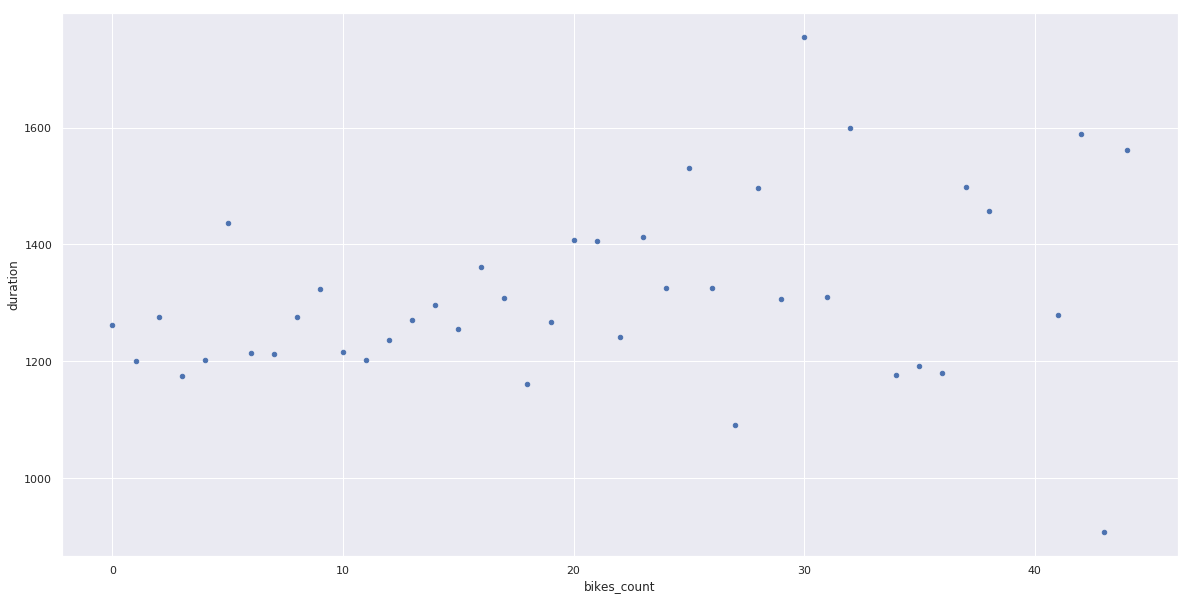

In [9]:
# 自転車数が多いほうが、durationが長いという仮説を検証
fig, ax = plt.subplots(figsize=(20,10))
ax=data.plot(x='bikes_count', y='duration', kind='scatter', ax=ax)


バイク数が多いと、利用時間は長くなるようにも見える

In [10]:
%%bigquery --project $PROJECT

SELECT CORR(ch.duration, cs.bikes_count) as corr
FROM `bigquery-public-data.london_bicycles.cycle_hire`　AS ch
JOIN `bigquery-public-data.london_bicycles.cycle_stations` AS cs
ON ch.start_station_name = cs.name

,corr
0,0.003655


相関係数はそこまで高くないので、ほぼ、無相関であるといえる

## 回帰モデル

## training dataset を生成
- 順序がある特徴量は INT64,FLOAT64にし、カテゴリ特徴量はSTRINGとする

In [12]:
%%bigquery  --project $PROJECT 

CREATE  OR REPLACE TABLE bq_ch09.dataset0 AS
SELECT
    duration,
    start_station_name,
    CAST(EXTRACT(dayofweek FROM start_date) AS STRING) AS dayofweek,
    CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
FROM `bigquery-public-data.london_bicycles.cycle_hire`

""


In [ ]:
%%bigquery  --project $PROJECT 
SELECT * FROM `bq_ch09.dataset0` limit 5

## modelを構築
- onehot encoding, 標準化、train,testの分割などは自動でやってくれるらしい

In [85]:
%%bigquery  --project $PROJECT 
CREATE MODEL  bq_ch09.bicycle_model
OPTIONS(input_label_cols=['duration'], model_type='linear_reg')
AS
SELECT * FROM `bq_ch09.dataset0`

""


## 性能評価

In [87]:
%%bigquery  --project $PROJECT 
SELECT * FROM ML.EVALUATE(MODEL bq_ch09.bicycle_model)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1025.592602,1.862407e+08,0.863502,542.351107,0.003625,0.003644


## datasetの改良
- 週末か否かでカテゴリ化
- 時間帯をbin化
- 日と時間の交差特徴量を追加

In [102]:
%%bigquery  --project $PROJECT 

CREATE   OR REPLACE TABLE bq_ch09.dataset1 AS
SELECT
    duration,
    start_station_name,
    IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 AND 6, 'weekday', 'weekend') AS dayofweek,
    ML.BUCKETIZE(EXTRACT(hour FROM start_date), [5, 10, 17]) AS hourofday,
    ML.FEATURE_CROSS(STRUCT(
    CAST(EXTRACT(day FROM start_date) AS STRING) AS day,
    CAST(EXTRACT(hour FROM start_date) AS STRING) AS hour
    )) AS dayhr
FROM `bigquery-public-data.london_bicycles.cycle_hire`

""


In [99]:
%%bigquery  --project $PROJECT 
SELECT * FROM `bq_ch09.dataset1` limit 5

,duration,start_station_name,dayofweek,hourofday,dayhr
0,2760,"Phillimore Gardens, Kensington",weekday,bin_3,{'day_hour': '10_13'}
1,2160,"Ashley Place, Victoria",weekday,bin_4,{'day_hour': '15_18'}
2,3120,"South Kensington Station, South Kensington",weekend,bin_3,{'day_hour': '21_12'}
3,11400,"Mexfield Road, East Putney",weekday,bin_3,{'day_hour': '2_10'}
4,2100,"Duke Street Hill, London Bridge",weekday,bin_4,{'day_hour': '4_17'}


In [107]:
%%bigquery  --project $PROJECT 
CREATE  OR REPLACE MODEL  bq_ch09.bicycle_model
OPTIONS(input_label_cols=['duration'], model_type='linear_reg')
AS
SELECT * FROM `bq_ch09.dataset1`

""


In [108]:
%%bigquery  --project $PROJECT 
SELECT * FROM ML.EVALUATE(MODEL bq_ch09.bicycle_model)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,864.683717,6.385412e+06,0.819285,540.313038,0.028645,0.02987


## TODO おそらくまだ未実装: 前処理をmodel側で行う場合TRANSFORMを使用

In [106]:
# %%bigquery  --project $PROJECT 
# CREATE  OR REPLACE MODEL  bq_ch09.bicycle_model
# TRANSFORM(
#     *EXCEPT(start_date),
#     IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 AND 6, 'weekday', 'weekend') AS dayofweek,
#     ML.BUCKETIZE(EXTRACT(hour FROM start_date), [5, 10, 17]) AS hourofday,
#     ML.FEATURE_CROSS(STRUCT(
#     CAST(EXTRACT(day FROM start_date) AS STRING) AS day,
#     CAST(EXTRACT(hour FROM start_date) AS STRING) AS hour
#     )) AS dayhr
# )
# OPTIONS(input_label_cols=['duration'], model_type='linear_reg')
# AS
# SELECT * FROM `bigquery-public-data.london_bicycles.cycle_hire`


## 予測
現在時刻の特定の駅の貸出時間

In [13]:
# TODO TRANSFORM句があれば下記のように前処理をせずに予測が可能
# じゃないと、下記のように一々前処理する必要がある
# %%bigquery  --project $PROJECT 
# SELECT * FROM ML.PREDICT(MODEL bq_ch09.bicycle_model,
# (
# SELECT 
#     'Park Lane , Hyde Park' AS start_station_name,
#     CURRENT_TIMESTAMP() AS start_date
# ))

In [115]:
%%bigquery  --project $PROJECT 
SELECT * FROM ML.PREDICT(MODEL bq_ch09.bicycle_model,
(
SELECT 
    'Park Lane , Hyde Park' AS start_station_name,
    CURRENT_TIMESTAMP() AS start_date,
    IF(EXTRACT(dayofweek FROM  CURRENT_TIMESTAMP()) BETWEEN 2 AND 6, 'weekday', 'weekend') AS dayofweek,
    ML.BUCKETIZE(EXTRACT(hour FROM  CURRENT_TIMESTAMP()), [5, 10, 17]) AS hourofday,
    ML.FEATURE_CROSS(STRUCT(
    CAST(EXTRACT(day FROM CURRENT_TIMESTAMP()) AS STRING) AS day,
    CAST(EXTRACT(hour FROM  CURRENT_TIMESTAMP()) AS STRING) AS hour
    )) AS dayhr
))

,predicted_duration,start_station_name,start_date,dayofweek,hourofday,dayhr
0,2770.43216,"Park Lane , Hyde Park",2019-07-15 04:26:36.115720+00:00,weekday,bin_1,{'day_hour': '15_4'}


## modelの重み値確認

In [116]:
%%bigquery  --project $PROJECT 
SELECT * FROM ML.WEIGHTS(MODEL bq_ch09.bicycle_model)

,processed_input,weight,category_weights
0,start_station_name,NaN,"[{'weight': 7111.149165932823, 'category': 'Il..."
1,dayofweek,NaN,"[{'weight': -1579.697613759131, 'category': 'w..."
2,hourofday,NaN,"[{'weight': 59.043835892913194, 'category': 'b..."
3,dayhr_day_hour,NaN,"[{'weight': -17983.98546796411, 'category': '2..."
4,__INTERCEPT__,15442.996075,[]


# 分類モデル

## EDA

duraionのpercentile

In [19]:
%%bigquery q --project $PROJECT 

SELECT 
    APPROX_QUANTILES(duration, 10) AS q
FROM `bigquery-public-data.london_bicycles.cycle_hire`

In [21]:
q.values

array([[list([-3540, 300, 420, 540, 660, 840, 960, 1200, 1440, 1920, 2674020])]],
      dtype=object)

80%のbikeは30min以内には返却されている

## datasetを生成
- 30min以内ならば通勤、以上ならばロードバイクとする

In [22]:
%%bigquery  --project $PROJECT 

CREATE  OR REPLACE TABLE bq_ch09.dataset_cls0 AS
SELECT
    IF(duration>1800, 'roadbike', 'commuter') AS biketype,
    start_station_name,
    CAST(EXTRACT(dayofweek FROM start_date) AS STRING) AS dayofweek,
    CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
FROM `bigquery-public-data.london_bicycles.cycle_hire`

""


In [23]:
%%bigquery  --project $PROJECT 

SELECT * FROM `bq_ch09.dataset_cls0` LIMIT 5

,biketype,start_station_name,dayofweek,hourofday
0,roadbike,"Shoreditch High Street, Shoreditch",2,13
1,roadbike,"Stonecutter Street, Holborn",7,19
2,roadbike,"Whitehall Place, Strand",7,21
3,roadbike,"Ontario Street, Elephant & Castle",5,13
4,roadbike,"Warwick Road, Olympia",3,12


## model構築
今回は確率を予測したいので、logistic regression

In [26]:
%%bigquery  --project $PROJECT 
CREATE  OR REPLACE MODEL  bq_ch09.bicycle_model_cls
OPTIONS(input_label_cols=['biketype'], model_type='logistic_reg')
AS
SELECT * FROM `bq_ch09.dataset_cls0`

""


# クラスタリング

## dataset生成

- 駅をクラスタリングする

In [37]:
%%bigquery  --project $PROJECT 

CREATE OR REPLACE TABLE bq_ch09.stationstats AS 
WITH hires AS(
SELECT 
    h.start_station_name AS station_name,
    IF(EXTRACT(dayofweek FROM h.start_date) BETWEEN 2 AND 6, 'weekday', 'weekend') AS isweekday,
    h.duration,
    s.bikes_count,
    ST_DISTANCE(ST_GEOGPOINT(s.longitude, s.latitude), ST_GEOGPOINT(-0.1, 51.5))/1000 AS distance_from_city_center
FROM 
    `bigquery-public-data.london_bicycles.cycle_hire` as h
JOIN `bigquery-public-data.london_bicycles.cycle_stations` as s
ON h.start_station_id = s.id
WHERE EXTRACT(YEAR FROM  start_date) =2015
),
stationstats AS(
SELECT
    station_name,
    AVG(IF(isweekday='weekday', duration, NULL)) AS duration_weekdays,
    AVG(IF(isweekday='weekend', duration, NULL)) AS duration_weekends,
    COUNT(IF(isweekday='weekday', duration, NULL)) AS numtrips_weekdays,
    COUNT(IF(isweekday='weekend', duration, NULL)) AS numtrips_weekends,
    MAX(bikes_count)  AS bikes_count,
    MAX(distance_from_city_center) AS distance_from_city_center
FROM hires
GROUP BY station_name
)
SELECT * FROM stationstats

""


In [38]:
%%bigquery  --project $PROJECT 

SELECT * FROM bq_ch09.stationstats LIMIT 5

,station_name,duration_weekdays,duration_weekends,numtrips_weekdays,numtrips_weekends,bikes_count,distance_from_city_center
0,"Sugden Road, Clapham",1424.815371,2125.639652,3331,1493,0,5.572513
1,"Gun Makers Lane, Old Ford",2141.286371,2730.000000,1959,1076,0,6.045737
2,"Kensington Town Hall, Kensington",1196.496879,1809.107143,4967,1120,0,6.537377
3,"Finnis Street, Bethnal Green",949.218443,1024.787776,6116,1767,0,3.958272
4,"Bell Street , Marylebone",987.753643,1276.478405,10911,1806,0,5.173236


## modelの構築
- 標準化などは、bq側でよしなにやってくれる

In [46]:
%%bigquery  --project $PROJECT 

CREATE OR REPLACE MODEL bq_ch09.station_clusters
OPTIONS(
    model_type='kmeans',
    num_clusters=4,
    standardize_features=true) AS 
SELECT *EXCEPT(station_name) FROM bq_ch09.stationstats

""


## 予測

In [49]:
%%bigquery  --project $PROJECT 
SELECT *EXCEPT(nearest_centroids_distance)
FROM ML.PREDICT(MODEL bq_ch09.station_clusters,
(
    SELECT * FROM bq_ch09.stationstats
    WHERE REGEXP_CONTAINS(station_name, 'Kennington')
))

,CENTROID_ID,station_name,duration_weekdays,duration_weekends,numtrips_weekdays,numtrips_weekends,bikes_count,distance_from_city_center
0,2,"Cotton Garden Estate, Kennington",1572.919255,997.950000,5313,1600,9,1.117034
1,2,"Cleaver Street, Kennington",1228.805277,1239.416810,4093,1166,10,1.496792
2,2,"Doddington Grove, Kennington",1397.718976,1972.409639,7067,2158,11,1.468141
3,3,"Kennington Station, Kennington",1689.587692,3579.285714,4875,1848,12,1.298668
4,2,"Kennington Road , Vauxhall",1209.433313,1720.598319,8135,2975,16,0.891565
5,3,"Kennington Road Post Office, Oval",1994.025384,2396.924791,5279,1795,16,1.846033
6,4,"Kennington Lane Rail Bridge, Vauxhall",979.391995,1812.217790,20263,5014,23,2.175033
7,3,"Kennington Oval, Oval",1272.502860,1503.619247,9617,2868,24,2.083134
8,3,"Kennington Cross, Kennington",911.523878,1160.482215,15349,4189,41,1.462588
